In [16]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn import preprocessing
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [17]:
def plot_train_vs_test(train_scores, test_scores, points = {}, time = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
    plt.show()

    maxarg = list(test_scores.keys())[np.argmax(list(test_scores.values()))]
    print("AT", maxarg, test_scores[maxarg], "WITH", len(points), "ITERATIONS IN", time, "SECONDS")

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [18]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1900])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1900])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

In [19]:
data.X_train

array([[ 5.10501052e-01, -2.13809410e-01,  6.90007387e-01, ...,
        -3.17855918e-01, -8.86121429e-01,  2.22086097e-01],
       [ 1.98982485e-01, -8.43391555e-01, -1.28996462e+00, ...,
         6.41096724e-01,  5.43598160e-02,  1.03544641e+00],
       [ 8.22019620e-01,  1.94002424e+00, -2.87121655e-01, ...,
         4.19799961e-01, -2.41220004e-01,  2.99548984e-01],
       ...,
       [-4.24054650e-01, -1.53924551e+00,  1.50015022e-01, ...,
        -1.70324742e-01, -2.14349111e-01, -3.58885555e-01],
       [-1.82588820e+00, -5.45168434e-01, -1.10996716e+00, ...,
        -6.86683858e-01,  6.18030532e-04, -1.03025640e-02],
       [ 4.32232012e-02,  5.15180442e-01,  8.44290920e-01, ...,
        -7.60449445e-01,  1.04858285e+00,  7.25594862e-01]])

# Random Selection

In [20]:
@time_func
def RANDOM_SELECTION(CVal = 10):
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*6)
    
    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

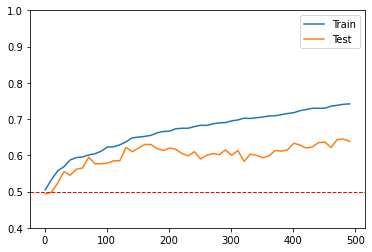

AT 481 0.6450000000000001 WITH 0 ITERATIONS IN -1 SECONDS
__main__.RANDOM_SELECTION - 00:00:11.529471200


In [21]:
RANDOM_SELECTION()

# SVM-RFE

In [22]:
@time_func
def SVM_RFE_NO_STEP():
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, 1) for test_index, train_index in kf.split(data.X_train)]
    with Pool(6) as pool:
        scores = pool.map(data.svm_rfe, index)

    #scores = list(map(data.svm_rfe, index))

    scores = list(scores)
    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, {}, time)

In [23]:
#SVM_RFE_NO_STEP()

# SVM-RFE with Step


In [24]:
@time_func
def SVM_RFE_W_STEP(step):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, step) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, points, time)

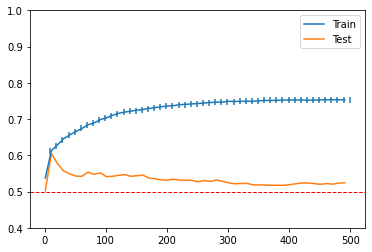

AT 11 0.6047368421052634 WITH 50 ITERATIONS IN 10.50461151599884 SECONDS
__main__.SVM_RFE_W_STEP - 00:01:06.560795800


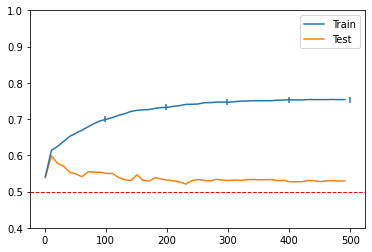

AT 11 0.598421052631579 WITH 5 ITERATIONS IN 1.6362563133239747 SECONDS
__main__.SVM_RFE_W_STEP - 00:00:47.890697400


In [25]:
#SVM_RFE_W_STEP(2)
#SVM_RFE_W_STEP(5)
SVM_RFE_W_STEP(10)
#SVM_RFE_W_STEP(50)
SVM_RFE_W_STEP(100)
#SVM_RFE_W_STEP(200)
#SVM_RFE_W_STEP(300)

# SVM-RFE with Sampling

In [26]:
def plot_train_vs_test(train_scores, test_scores, spoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    plt.scatter(spoint[0], spoint[1], s=10, c='red')
    w = [-wo[1]/n_features, wo[0]]
    b = w[0]*spoint[0] + w[1]*spoint[1]
    xleft, xright = plt.xlim()
    xd = np.array([xleft, xright])
    yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
    plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

In [27]:
@time_func
def SVM_RFE_SAMPLING(step, percentage = 0.5, w1 = [0.8, 0.2]):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step, percentage) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_sampling, index)

    #scores = list(map(data.svm_rfe_sampling, index))
    scores = list(scores)

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)

In [28]:
#SVM_RFE_SAMPLING(10, 0.5)

(1900, 500) (1805,) (95,)


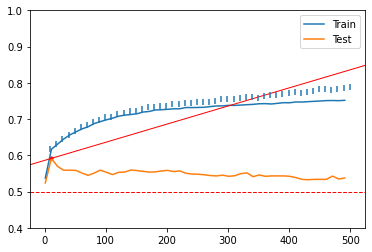

AT (11, 0.5915789473684211, 0.3311368421052632) WITH 50 ITERATIONS IN 12.487518143653869 SECONDS : 1.0019873428369301
__main__.SVM_RFE_SAMPLING - 00:01:14.447846500


In [29]:
SVM_RFE_SAMPLING(10, 0.8)

(1900, 500) (1805,) (95,)


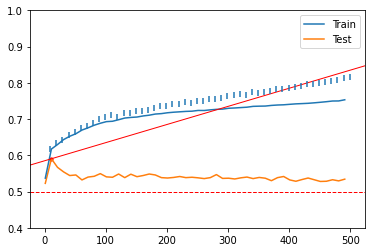

AT (11, 0.5905263157894737, 0.3319789473684211) WITH 50 ITERATIONS IN 11.719221770763397 SECONDS : 0.6695860377117178
__main__.SVM_RFE_SAMPLING - 00:01:11.850568300


In [30]:
SVM_RFE_SAMPLING(10, 0.7)

(1900, 500) (1805,) (95,)


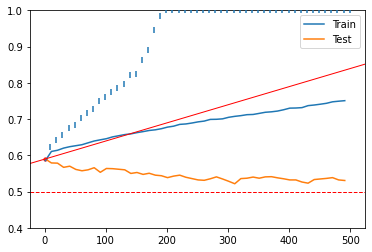

AT (1, 0.59, 0.3284000000000001) WITH 50 ITERATIONS IN 109.19821623563766 SECONDS : 62.3106330400981
__main__.SVM_RFE_SAMPLING - 00:05:57.252135300


In [31]:
SVM_RFE_SAMPLING(10, 0.2)

(1900, 500) (1805,) (95,)


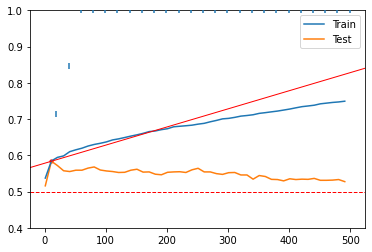

AT (11, 0.5836842105263159, 0.3374526315789473) WITH 25 ITERATIONS IN 1.1641358256340026 SECONDS : 0.007254016982554248
__main__.SVM_RFE_SAMPLING - 00:00:35.069954000


In [32]:
SVM_RFE_SAMPLING(20, 0.05)

(1900, 500) (1805,) (95,)


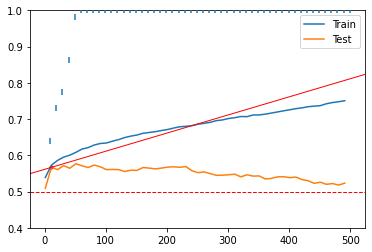

AT (11, 0.5668421052631578, 0.3509263157894738) WITH 50 ITERATIONS IN 2.358470320701599 SECONDS : 0.018378335240507228
__main__.SVM_RFE_SAMPLING - 00:00:37.754779900


In [33]:
SVM_RFE_SAMPLING(10, 0.05)

(1900, 500) (1805,) (95,)


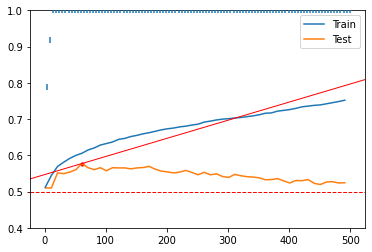

AT (61, 0.5773684210526315, 0.3625052631578948) WITH 100 ITERATIONS IN 0.7303723573684693 SECONDS : 0.02218012732574323
__main__.SVM_RFE_SAMPLING - 00:00:34.351668600


In [34]:
SVM_RFE_SAMPLING(5, 0.01)

(1900, 500) (1805,) (95,)


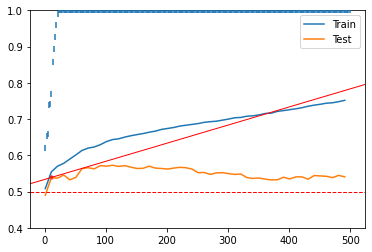

AT (11, 0.5389473684210526, 0.37324210526315793) WITH 250 ITERATIONS IN 2.925491118431091 SECONDS : 0.04019039226419011
__main__.SVM_RFE_SAMPLING - 00:00:39.940086800


In [35]:
SVM_RFE_SAMPLING(2, 0.02)

(1900, 500) (1805,) (95,)


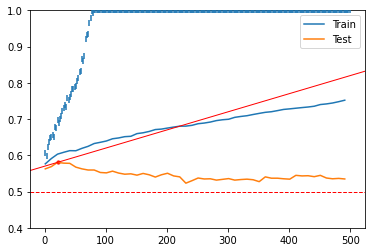

AT (21, 0.5805263157894737, 0.3439789473684211) WITH 250 ITERATIONS IN 38.884308624267575 SECONDS : 14.220955008448447
__main__.SVM_RFE_SAMPLING - 00:02:27.679823800


In [36]:
SVM_RFE_SAMPLING(2, 0.08)